✅ 파생변수 포함 완료!
최종 학습 데이터 크기: (8000, 21)
데이터 크기 확인: X=8000, y=8000
적용 임계값(Threshold): 0.4
------------------------------------------------------------
✅ Logistic Regression 학습 및 Recall 최적화 완료
✅ Random Forest 학습 및 Recall 최적화 완료
✅ XGBoost 학습 및 Recall 최적화 완료
✅ LightGBM 학습 및 Recall 최적화 완료

[5-Fold Cross Validation - Recall Optimized]
              Model      AUC  F1-Score   Recall  Precision
Logistic Regression 0.841444  0.521825 0.859509   0.374673
      Random Forest 0.858718  0.578909 0.781595   0.459812
            XGBoost 0.862530  0.578514 0.809816   0.450100
           LightGBM 0.862003  0.579770 0.815337   0.449957


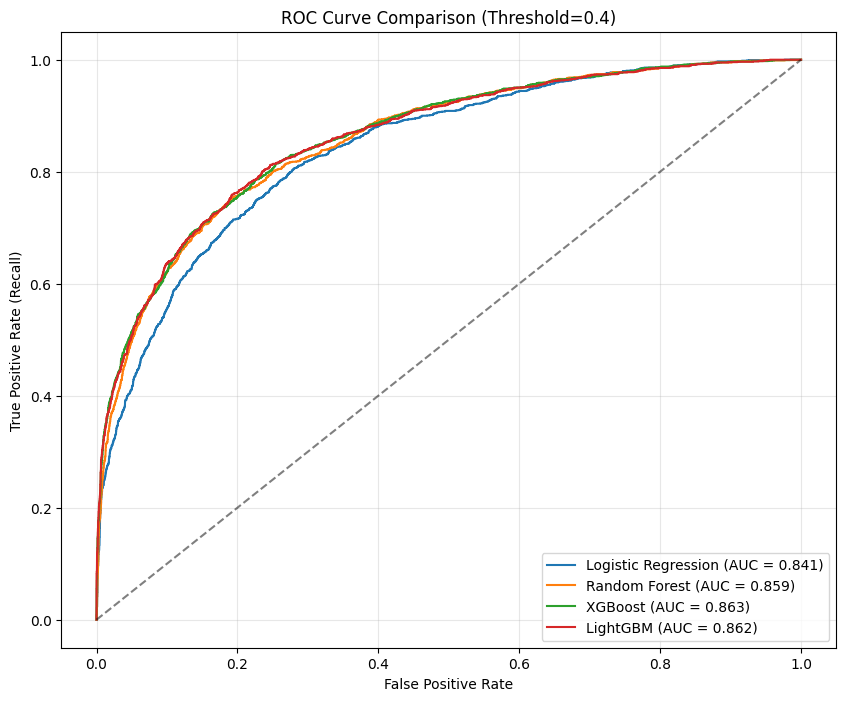

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, auc, f1_score, recall_score, roc_auc_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')

class CustomWinsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, limits=[0.05, 0.05]):
        self.limits = limits
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        from scipy.stats.mstats import winsorize
        X_copy = X.copy()
        if isinstance(X_copy, pd.DataFrame):
            for col in X_copy.columns:
                X_copy[col] = winsorize(X_copy[col], limits=self.limits)
        else:
            X_copy = winsorize(X_copy, limits=self.limits)
        return X_copy

num_cols = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Point Earned']
cat_cols = ['Geography', 'Gender', 'Card Type']
pass_cols = ['HasBalance', 'Age_Group', 'IsActiveMember', 'NumOfProducts', 'Prod_is_1', 'ZeroBal_Prod2', 'Inactive_Old']
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('winsorizer', CustomWinsorizer()),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('pass', 'passthrough', pass_cols)
])
# --- [1] 파생변수 생성 함수 정의 ---
def add_custom_features(df):
    X = df.copy()
    X['HasBalance'] = (X['Balance'] > 0).astype(int)
    X['BalanceSalaryRatio'] = X['Balance'] / (X['EstimatedSalary'] + 1e-6)
    X['Age_Group'] = pd.cut(X['Age'], bins=[0, 30, 45, 60, 100], labels=[0, 1, 2, 3]).astype(int)
    X['Prod_is_1'] = (X['NumOfProducts'] == 1).astype(int)
    X['Prod_is_2'] = (X['NumOfProducts'] == 2).astype(int)
    X['Prod_ge_3'] = (X['NumOfProducts'] >= 3).astype(int)
    X['ZeroBal_Prod2'] = ((X['Balance'] == 0) & (X['NumOfProducts'] == 2)).astype(int)
    X['ZeroBal_Prod1'] = ((X['Balance'] == 0) & (X['NumOfProducts'] == 1)).astype(int)
    X['Prod2_Inactive'] = ((X['NumOfProducts'] == 2) & (X['IsActiveMember'] == 0)).astype(int)
    X['Inactive_Old'] = ((X['IsActiveMember'] == 0) & (X['Age'] >= 45)).astype(int)
    return X

# --- [2] 데이터 로드 및 1차 분할 (8:2) ---
df = pd.read_csv('./Customer-Churn-Records.csv')
X = df.drop(['RowNumber', 'CustomerId', 'Surname', 'Exited'], axis=1)
y = df['Exited']

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- [3] 파생변수 적용 및 전처리 ---
# 80% 데이터 전체에 파생변수 생성
X_train_full_enriched = add_custom_features(X_train_full)
X_test_enriched = add_custom_features(X_test)

# 파이프라인 적용
X_train_final = preprocessor.fit_transform(X_train_full_enriched)
X_test_final = preprocessor.transform(X_test_enriched)

print(f"✅파생변수 포함 완료!")
print(f"최종 학습 데이터 크기: {X_train_final.shape}") 



# 1. 모델 정의 (불균형 데이터 처리를 위한 가중치 옵션 추가)
# 이전 단일 모델에서 효과를 보셨던 scale_pos_weight=4를 기준으로 설정합니다.
models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000, 
        class_weight='balanced', 
        C=0.1,             # 규제 강도 (작을수록 강한 규제, 과적합 방지)
        solver='liblinear', # 작은 데이터셋이나 이진 분류에 안정적
        random_state=42
    ),
    
    'Random Forest': RandomForestClassifier(
        n_estimators=200,    # 트리를 더 많이 쌓아 안정성 확보
        class_weight='balanced', 
        max_depth=10,        # 너무 깊은 트리는 과적합을 유발하므로 제한
        min_samples_leaf=5,  # 한 잎 노드에 최소 샘플 수 (일반화 성능 향상)
        random_state=42
    ),
    
   'XGBoost': XGBClassifier(
    n_estimators=500,        # 트리 개수를 늘림 (정교함 상승)
    learning_rate=0.01,      # 아주 낮게 설정하여 천천히 정밀하게 학습
    max_depth=6,             # 트리 깊이를 6으로 제한 (과적합 방지)
    min_child_weight=5,      # 관측치 수가 적은 노드 분할 억제 (일반화 성능)
    gamma=0.2,               # 분할을 위한 최소 손실 감소 값 (트리 복잡도 제어)
    subsample=0.8,           # 행 데이터의 80%만 무작위 사용 (폴드별 안정성)
    colsample_bytree=0.8,     # 열 변수의 80%만 무작위 사용 (특정 변수 편향 방지)
    scale_pos_weight=4,      # 이탈자(1) 가중치 (Recall 방어)
    reg_alpha=0.1,           # L1 규제 (불필요한 변수 가중치 제거)
    reg_lambda=1.0,          # L2 규제 (가중치 크기 억제)
    random_state=42,
    eval_metric='logloss'
),
    
'LightGBM': LGBMClassifier(
    n_estimators=500,
    learning_rate=0.01,
    num_leaves=31,           # max_depth가 6~7일 때 가장 적절한 복잡도
    max_depth=6,             # 과적합 방지를 위해 트리 깊이 제한
    min_data_in_leaf=20,     # 한 잎에 포함될 최소 데이터 수 (안정성 강화)
    feature_fraction=0.8,    # 트리 구축 시 변수 샘플링 비율 (XGB의 colsample과 유사)
    bagging_fraction=0.8,     # 데이터 샘플링 비율
    bagging_freq=5,          # 5번의 반복마다 배깅 수행
    scale_pos_weight=4,
    lambda_l1=0.1,           # L1 규제
    lambda_l2=0.1,           # L2 규제
    random_state=42,
    verbose=-1
)
}


# 2. K-Fold 및 설정
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
custom_threshold = 0.4  # Recall 확보를 위해 임계값을 0.4로 하향 조정 (기본값 0.5)

plt.figure(figsize=(10, 8))
results = []

print(f"데이터 크기 확인: X={X_train_final.shape[0]}, y={len(y_train_full)}")
print(f"적용 임계값(Threshold): {custom_threshold}")
print("-" * 60)

# 3. 모델별 학습 및 K-Fold 평가
for name, model in models.items():
    oof_probs = np.zeros(len(y_train_full))
    fold_aucs, fold_f1s, fold_recalls, fold_precisions = [], [], [], []

    for train_idx, val_idx in skf.split(X_train_final, y_train_full):
        X_kf_train, X_kf_val = X_train_final[train_idx], X_train_final[val_idx]
        y_kf_train, y_kf_val = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]
        
        model.fit(X_kf_train, y_kf_train)
        
        # 확률값 계산
        probs = model.predict_proba(X_kf_val)[:, 1]
        
        # [핵심] 임계값 적용: 0.5가 아닌 0.4를 기준으로 클래스 결정
        preds = (probs >= custom_threshold).astype(int)
        
        fold_aucs.append(roc_auc_score(y_kf_val, probs))
        fold_f1s.append(f1_score(y_kf_val, preds))
        fold_recalls.append(recall_score(y_kf_val, preds))
        fold_precisions.append(precision_score(y_kf_val, preds))
        
        oof_probs[val_idx] = probs

    # 결과 평균 계산
    avg_auc = np.mean(fold_aucs)
    avg_f1 = np.mean(fold_f1s)
    avg_recall = np.mean(fold_recalls)
    avg_precision = np.mean(fold_precisions)
    results.append([name, avg_auc, avg_f1, avg_recall, avg_precision])

    # ROC 커브 시각화
    fpr, tpr, _ = roc_curve(y_train_full, oof_probs)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {avg_auc:.3f})')
    print(f"✅ {name} 학습 및 Recall 최적화 완료")

# 4. 성능 지표 테이블 출력
df_res = pd.DataFrame(results, columns=['Model', 'AUC', 'F1-Score', 'Recall', 'Precision'])
print("\n[5-Fold Cross Validation - Recall Optimized]")
print(df_res.to_string(index=False))

# 5. ROC 커브 시각화 마무리
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title(f'ROC Curve Comparison (Threshold={custom_threshold})')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()